In [1]:
import os
import pickle

import numpy as np
import pandas as pd

import operator

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from scipy.stats import binom
from scipy.stats import entropy
from scipy.stats import pearsonr

import zarr
import dask.array as da

from utils.utility_functions import transposeZarr, log_transform, clip_outlier_pixels

In [2]:
# Paths and input
out = os.path.join(os.getcwd(), 'output/VAE20_entropy_by_VAE9_ROT_VIG18')
if not os.path.exists(out):
    os.makedirs(out)

# Read single-cell data from VAE analysis
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))

# Optional: filter VAE20 clusters to analyze according to their abundance
filt = main.groupby('VAE20_Leiden').size()
filt = filt.index[filt > 0]
filt = filt.tolist()

df = main[main['VAE20_Leiden'].isin(filt)]
df = df[df['VAE20_Leiden'] != -1]
df = df[df['VAE9_ROT_VIG18'] != -1]

count_headers = [f'VAE9_{i}' for i in sorted(df['VAE9_ROT_VIG18'].unique())]

In [3]:
if not os.path.exists(os.path.join(out, 'counts_minus_ref.csv')):

    counts = pd.DataFrame(columns=['VAE20', 'VAE9'] + count_headers)

    for vae_cluster, group in df.groupby('VAE20_Leiden'):
        print(vae_cluster)
        for i in group.iterrows():
            dta = pd.DataFrame(columns=['VAE20', 'VAE9'] + count_headers)
            dta.loc[0, 'VAE20'] = vae_cluster
            dta.loc[0, 'VAE9'] = int(i[1]['VAE9_ROT_VIG18'])
            dta.loc[0, count_headers] = 0

            # isolate cells within 30x30pixel area (20x20um)
            x = i[1]['X_centroid']
            y = i[1]['Y_centroid']
            patch = (
                df[(df['Y_centroid'].between(y - 15, y + 15)) &
                    (df['X_centroid'].between(x - 15, x + 15))].copy()
            )

            cnts = patch.groupby('VAE9_ROT_VIG18').size()

            for j in cnts.index:
                dta.loc[0, f'VAE9_{j}'] = cnts[j]
            counts = pd.concat([counts, dta], axis=0)

    counts.reset_index(drop=True, inplace=True)
    counts.to_csv(os.path.join(out, 'counts2.csv'), index=False)

    # subtract reference cells from counts table
    for idx, dta in counts.iterrows():
        if idx % 10000 == 0:
            print(idx)
        current = counts.loc[idx, f"VAE9_{dta['VAE9']}"]
        counts.loc[idx, f"VAE9_{dta['VAE9']}"] = (current - 1)
    counts.to_csv(os.path.join(out, 'counts_minus_ref.csv'), index=False)

else:
    # Read reference cell substracted counts table
    counts = pd.read_csv(os.path.join(out, 'counts_minus_ref.csv'))

In [4]:
# Compute VAE20 cluster enrichment pvals

# scipy.stats.binom.cdf(k, n, p)

# k: float or array_like of floats representing random variable
# (i.e. how many cells of a particular VAE9 cluster are
#  in a given VAE20 cluster's image patches)

# n: number of trials, must be >= 0
# (i.e. how many cells are in a given VAE20 cluster)

# p: probability of success in each trial, must be in range [0, 1]
# (i.e. what is the frequency of a given VAE9 cluster in the dataset)

counts = counts[counts['VAE20'].isin(df['VAE20_Leiden'].unique())]

ppp = counts.groupby('VAE9').size() / len(counts)
ppp.index = [f'VAE9_{i}' for i in ppp.index]

nnn = counts.groupby(['VAE20']).size()

kkk = counts.loc[:, counts.columns != 'VAE9'].groupby(['VAE20']).sum()

pvals = kkk.copy().astype('float')
for vae_cluster in kkk.index:
    for vae_cluster_w14 in kkk.columns:

        # Plot CDF
        if (vae_cluster == 35) and (vae_cluster_w14 == 'VAE9_0'):
            x = np.arange(0, nnn[vae_cluster], 0.01)
            y = binom.cdf(k=x, n=nnn[vae_cluster], p=ppp[vae_cluster_w14])
            plt.plot(x, y, c='k')
            plt.tight_layout()
            plt.savefig(os.path.join(out, 'V35_cdf.pdf'))
            plt.close('all')

        # Compute pval at specific x-coordinate in CDF
        k = kkk.loc[vae_cluster, vae_cluster_w14]
        pval = 1 - binom.cdf(k=k, n=nnn[vae_cluster], p=ppp[vae_cluster_w14])
        pvals.loc[vae_cluster, vae_cluster_w14] = pval

In [5]:
# Compute Shannon entropy for VAE20 clusters with respect to VAE9 cluster heterogeneity
entropies = {}
for vae_cluster, group in df.groupby('VAE20_Leiden'):
    percents = group.groupby('VAE9_ROT_VIG18').size() / len(group)
    percents_pad = percents.reindex(sorted(df['VAE9_ROT_VIG18'].unique()), fill_value=0.0)
    entropies[vae_cluster] = entropy(pk=percents_pad, base=2)

# Sort entropy scores in ascending order
entropies = dict(sorted(entropies.items(), key=operator.itemgetter(1), reverse=False))

e1 = pd.DataFrame.from_dict(entropies, orient='index')
e1.rename(columns={0: 'entropy'}, inplace=True)

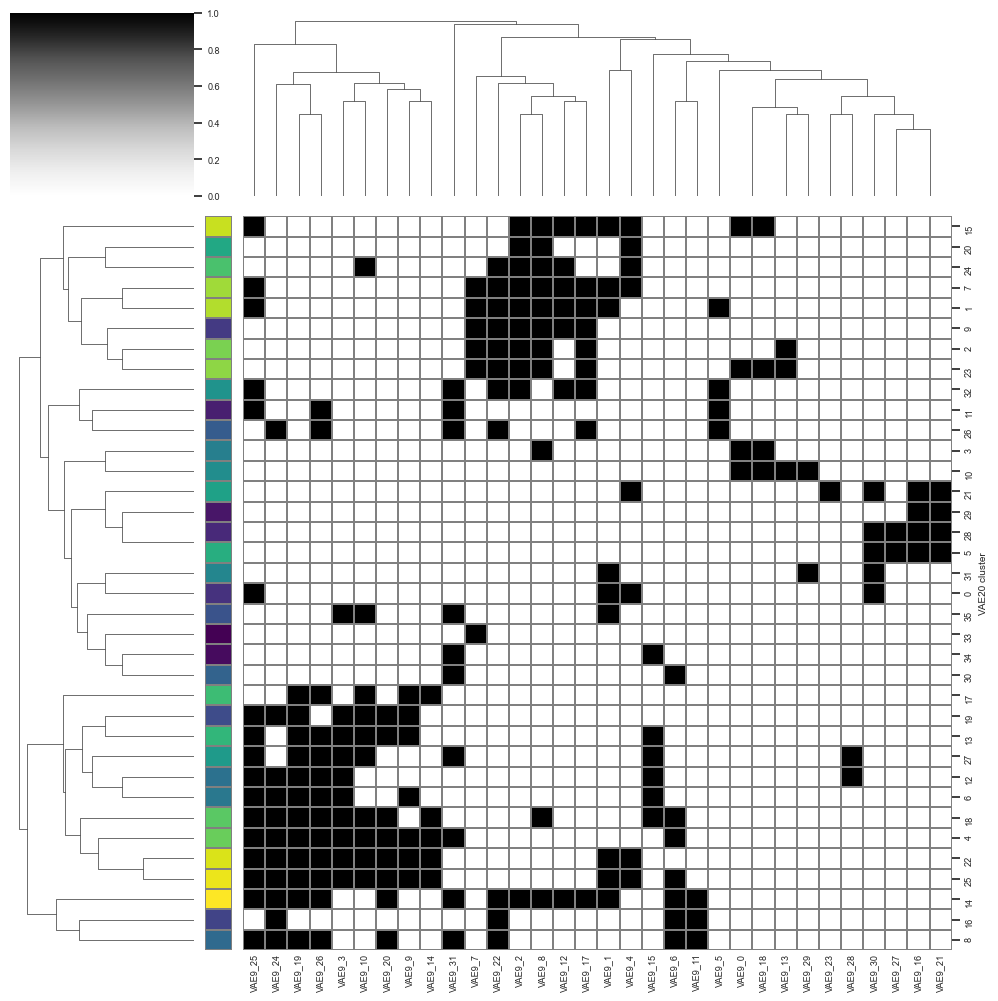

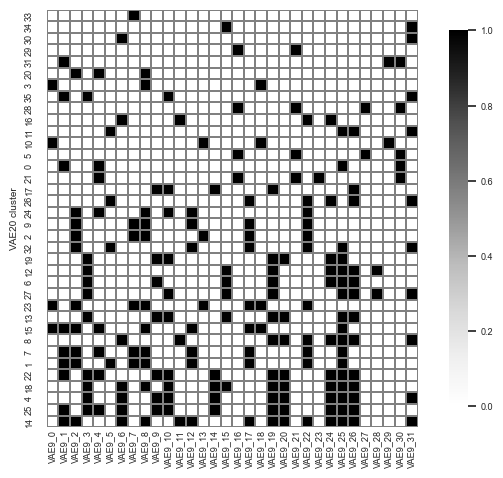

In [6]:
# Plot heatmap of CDF pvals
sns.set(font_scale=0.6)
sns.set_style('white')
heatmap = pvals[pvals <= 0.05]
heatmap = heatmap.notnull().astype('int')

test = heatmap.sum(axis=1)
test2 = df.groupby('VAE20_Leiden').size()
test3 = test2.reindex(test.index)

test4 = pd.DataFrame(data={'VAE9_count': test, 'size': test3})
test4 = test4.sort_values(['VAE9_count', 'size'])
heatmap = heatmap.reindex(test4.index)

# Divide viridis colors into to the number of VAE clusters
viridis = plt.get_cmap('viridis', heatmap.shape[0])
# Map VAE clusters to their entropy scores
ent = dict(zip(heatmap.index, [entropies[i] for i in heatmap.index]))
# Sort the dict by entropy scores (i.e., values)
ent = {k: v for k, v in sorted(ent.items(), key=lambda item: item[1])}
# Map VAE clusters in heatmap, sorted by entropy, onto viridis colors
lut = dict(zip(ent.keys(), viridis.colors))
# Create colors index
row_colors = heatmap.index.map(lut)

g = sns.clustermap(
    heatmap, xticklabels=1, yticklabels=1, cmap='Greys', linecolor='grey',
    linewidths=0.3, cbar_kws={'shrink': 0.9}, row_colors=row_colors
)
g.ax_heatmap.set_ylabel('VAE20 cluster')
g.ax_heatmap.get_xaxis().set_tick_params(pad=-4)
plt.tight_layout()
plt.savefig(os.path.join(out, 'pvals_clustermap.pdf'))
plt.show()
plt.close('all')

sns.heatmap(
    heatmap, xticklabels=1, yticklabels=1, cmap='Greys', linecolor='grey',
    linewidths=0.3, square=True, cbar_kws={'shrink': 0.9}
)
plt.ylabel('VAE20 cluster')
plt.tick_params(axis='x', which='major', pad=-4)
plt.tight_layout()
plt.savefig(os.path.join(out, 'pvals_heatmap.pdf'))
plt.show()
plt.close('all')

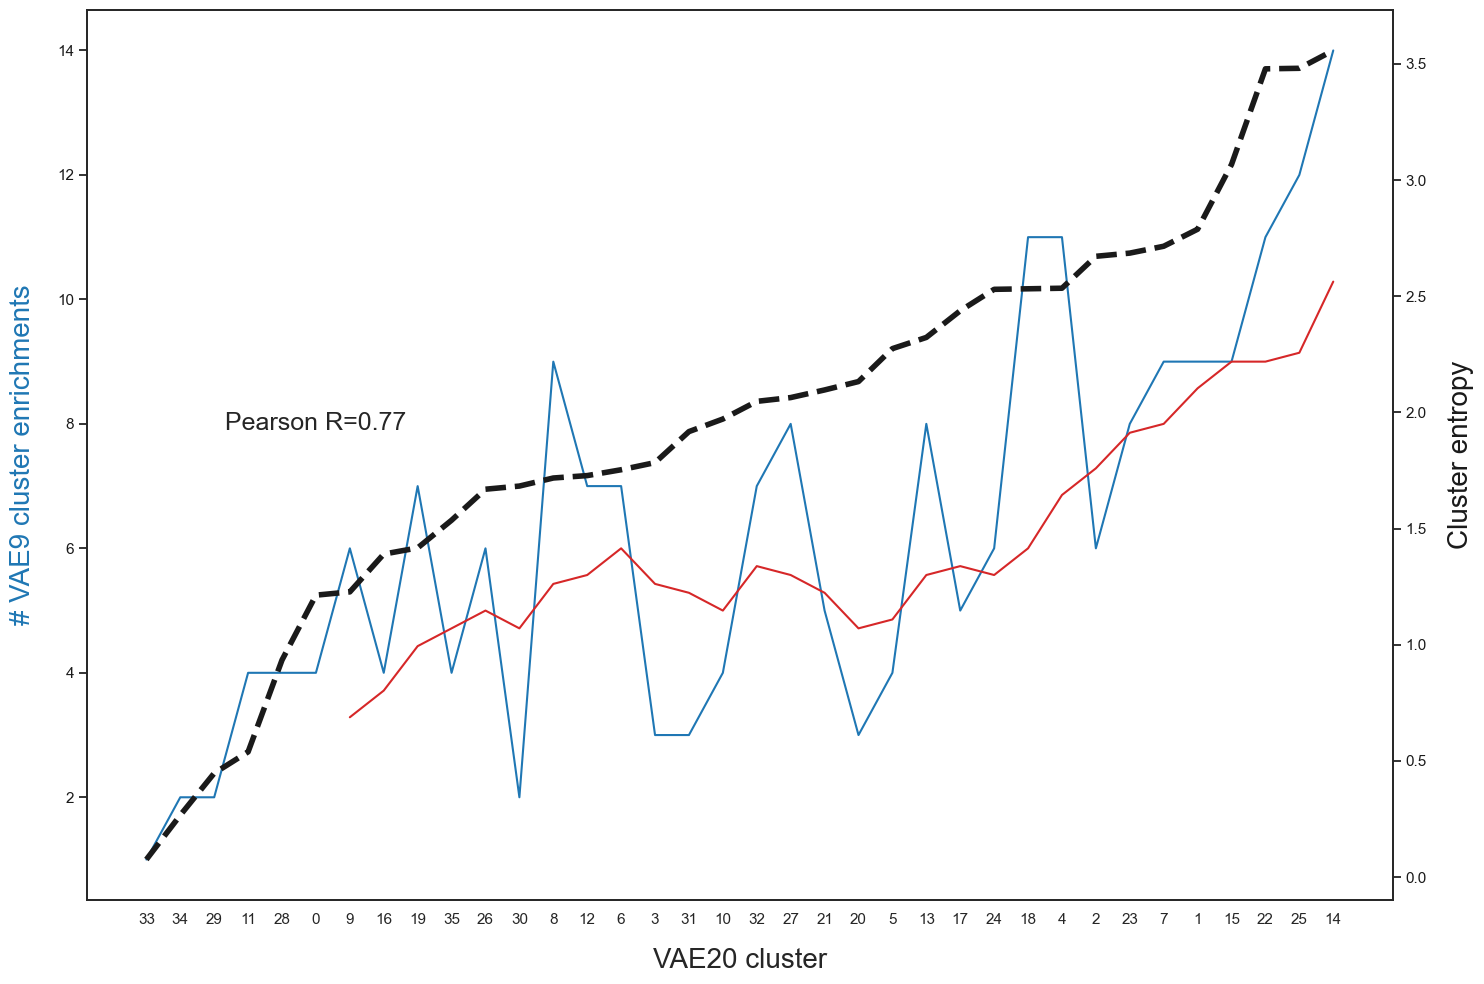

In [7]:
# Plot VAE20 cluster entropy and VAE9 cluster enrichments on shared y-axis
sns.set(font_scale=1.0)
sns.set_style('white')
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()

count_thresholds = heatmap.sum(axis=1).sort_values()
count_thresholds = count_thresholds.reindex(entropies.keys())

e1['VAE9_count'] = count_thresholds

ax1.plot(
    [str(i) for i in count_thresholds.index], count_thresholds.values,
    c='tab:blue', lw=1.5, linestyle='-')

# Plot rolling count threshold average
rolling = count_thresholds.rolling(7).mean()
rolling.dropna(inplace=True)
ax1.plot([str(i) for i in rolling.index], rolling.values, c='tab:red', lw=1.5, linestyle='-')

ax1.set_xlabel('VAE20 cluster', size=20, labelpad=15)
ax1.set_ylabel('# VAE9 cluster enrichments', size=20, labelpad=15, c='tab:blue')
ax1.tick_params(axis='y', colors='k')
ax2.plot([str(i) for i in entropies.keys()], entropies.values(), c='k', lw=4, linestyle='--')
ax2.set_ylabel('Cluster entropy', size=20, labelpad=15, c='k')
ax2.tick_params(axis='y', colors='k')

# Compute Pearson correlation coefficient
stat, pval = pearsonr(
    [i for i in entropies.values()], [i for i in count_thresholds.values], alternative='two-sided'
)
ax1.annotate(
    f'Pearson R={round(stat, 2)}', xy=(5, 8), horizontalalignment='center',
    verticalalignment='center', size=18
)
plt.tight_layout()
fig.savefig(os.path.join(out, 'entropy_vs_VAE9-enrichment.pdf'))
plt.show()
plt.close('all')

In [8]:
# Compute mean aggregate-channel intensities per VAE cluster
root = os.path.join(os.getcwd(), 'input/VAE20')
combo_dir = os.path.join(root, '6_latent_space_LD850/combined_zarr')

# Read percentile cutoffs selected in script 4_feature_preprocessing_selections
with open(
    os.path.join(root, '4_feature_preprocessing_selections/cutoffs.pkl'), 'rb'
    ) as handle:
    cutoffs = pickle.load(handle)

# Read combined training, validation, and test thumbnails, load into memory
X_combo = zarr.open(combo_dir)
X = transposeZarr(z=X_combo)  # X is now a dask array
X = X[df.index, :, :, :]

# Log-transform and clip outliers of image patch sample
X = clip_outlier_pixels(log_transform(X), cutoffs)

mean_signals = pd.DataFrame(columns=['mean', 'std', 'q25', 'q50', 'q75', 'VAE20'])

means = X.sum(axis=3).mean(axis=(1, 2)).compute()
stds = X.sum(axis=3).std(axis=(1, 2)).compute()

q25, q50, q75 = np.percentile(
    X.sum(axis=3).reshape(X.sum(axis=3).shape[0], -1).compute(), [25, 50, 75], axis=1
)

# Normalize pixels 0-1
# img = ((img - np.min(img)) / (np.max(img) - np.min(img)).astype('float32'))

mean_signals['VAE20'] = df['VAE20_Leiden']
mean_signals['mean'] = means
mean_signals['std'] = stds
mean_signals['q25'] = q25
mean_signals['q50'] = q50
mean_signals['q75'] = q75

# Drop unclustered cells before plotting clustermap
mean_signals = mean_signals.groupby('VAE20').mean()

e1['mean'] = mean_signals['mean']
e1['std'] = mean_signals['std']
e1['q25'] = mean_signals['q25']
e1['q50'] = mean_signals['q50']
e1['q75'] = mean_signals['q75']

e1.to_csv(os.path.join(out, 'regression_variables.csv'))

KeyboardInterrupt: 

In [ ]:
# Plot VAE20 cluster entropy and mean aggregate patch intensity on shared y-axis
mean_signals = mean_signals.reindex(entropies.keys())

sns.set(font_scale=1.0)
sns.set_style('white')
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()
ax1.plot(
    [str(i) for i in mean_signals.index], mean_signals['mean'], c='tab:blue', lw=1.5, linestyle='-'
)
ax1.set_xlabel('VAE20 Cluster', size=20, labelpad=15)
ax1.set_ylabel('Mean aggregate patch intensity', size=20, labelpad=15, c='tab:blue')
ax1.tick_params(axis='y', colors='k')
ax2.plot([str(i) for i in entropies.keys()], entropies.values(), c='k', lw=4, linestyle='--')
ax2.set_ylabel('Cluster entropy', size=20, labelpad=15, c='k')
ax2.tick_params(axis='y', colors='k')

# Compute Pearson correlation coefficient
stat, pval = pearsonr(
    [i for i in entropies.values()], [i for i in mean_signals['mean'].values],
    alternative='two-sided'
)
ax2.annotate(
    f'Pearson R={round(stat, 3)}', xy=(4.0, 2.9),
    horizontalalignment='center', verticalalignment='center', size=18
)
plt.tight_layout()
fig.savefig(os.path.join(out, 'entropy_vs_mean-agg-signals.pdf'))
plt.show()
plt.close('all')

7 out of 36 VAE20 clusters (~20%) with a single VAE9 cluster composition of >=80%


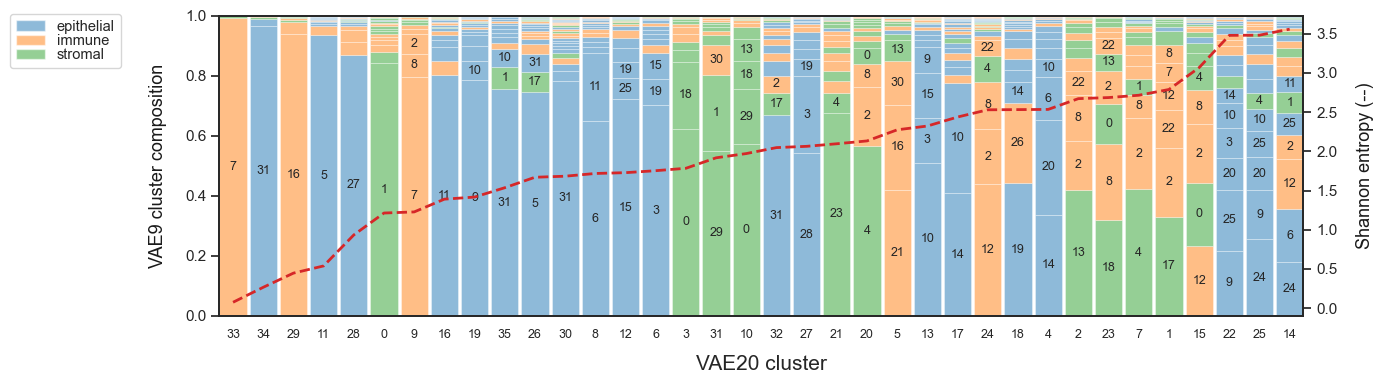

In [13]:
# Plot stacked barcharts
bar = df.groupby(['VAE20_Leiden', 'VAE9_ROT_VIG18']).size().unstack().fillna(0)

# Normalize VAE9 counts per VAE20 cluster (0-1), sort VAE clusters by entropy
bar = bar.div(bar.sum(axis=1), axis=0)
bar = bar.reindex(entropies.keys())
bar.columns = bar.columns.astype('str')

vals = bar.values.copy()
vals.sort(axis=1)
pbar = pd.DataFrame(index=bar.index, columns=bar.columns, data=vals)
pbar.plot.bar(stacked=True, lw=0.0, legend=False, width=1.0, colormap='tab20')
plt.tight_layout()
plt.savefig(os.path.join(out, 'stacked_bar.pdf'))
plt.close('all')

fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()
x = bar.index.astype('str')
indexes = np.argsort(bar.values).T
heights = np.sort(bar.values).T
order = -1
bottoms = heights[::order].cumsum(axis=0)
bottoms = np.insert(bottoms, 0, np.zeros(len(bottoms[0])), axis=0)

# make color dict
epithelial = [24, 25, 20, 14, 31, 9, 10, 3, 5, 6, 11, 15, 19, 27, 28] 
immune = [26, 30, 8, 12, 16, 21, 7, 2, 22]
stromal = [1, 4, 13, 18, 29, 0, 17, 23]
mpp_colors = {}
mpp_colors.update({str(k): v for k, v in zip(epithelial, ['tab:blue']*len(epithelial))})
mpp_colors.update({str(k): v for k, v in zip(immune, ['tab:orange']*len(immune))})
mpp_colors.update({str(k): v for k, v in zip(stromal, ['tab:green']*len(stromal))})
from math import ceil
for btms, (idxs, vals) in enumerate(list(zip(indexes, heights))[::order]):

    mps = np.take(np.array(bar.columns), idxs)
    if btms == 0:
        print(
            f'{len([v for v in vals if v >= 0.8])} out of {len(vals)} VAE20 clusters '
            f'(~{ceil(len([v for v in vals if v >= 0.8])/len(vals)*100)}%) with a single '
            'VAE9 cluster composition of >=80%'
        )
    # IF YOU DONT WANT TO COLOR THE BARS, USE THIS CODE
    # g = ax1.bar(
    #     x, height=vals, width=0.9, color='w', lw=0.1, ec='k',
    #     bottom=bottoms[btms]
    #     )
    
    g = ax1.bar(
        x, height=vals, width=0.9, lw=0.5, bottom=bottoms[btms],
        color=[mpp_colors[m] for m in mps], alpha=0.5
        )

    pos = -1
    for i, b in enumerate(g.patches):
        if i % len(bar.index) == 0:
            pos += 1
        xloc = b.get_x() + 0.45
        yloc = b.get_y() + b.get_height()/2
        if b.get_height() > 0.05:
            ax1.annotate(
                mps[i], xy=(xloc, yloc), fontname='Arial',
                va='center', ha='center', size=9
                )

ax1.set_xlabel('VAE20 cluster', size=15, labelpad=10)
ax1.set_ylabel('VAE9 cluster composition', size=13, labelpad=13, c='k')
ax1.tick_params(axis='x', which='major', labelsize=9)
ax1.margins(x=0)

patches = [
    Patch(facecolor=color, alpha=0.5, edgecolor=None) for color in ['tab:blue', 'tab:orange', 'tab:green']
    ]
plt.legend(
    patches, ['epithelial', 'immune', 'stromal'],
    title=None, prop={'size': 10.5},
    labelspacing=0.01, bbox_to_anchor=[-0.2, 1.03], loc='upper left'
    )

ax2.plot(
    [str(i) for i in entropies.keys()], entropies.values(),
    c='tab:red', lw=2, linestyle='--'
    )
ax2.set_ylabel('Shannon entropy (--)', size=13, labelpad=13, c='k')

plt.tight_layout()
plt.savefig(os.path.join(out, 'stacked_bar_new.pdf'))
plt.show()
plt.close('all')


In [19]:
indices_80_percent = {}
test = bar.T

# Iterate over each column
for column in test.columns:
    # Sort the column values in ascending order
    sorted_column = test[column].sort_values(ascending=False)

    # Calculate cumulative sum
    indices_below_80_percent = []
    cumulative_sum = sorted_column.cumsum()
    for e, (idx, val) in enumerate(cumulative_sum.items()):
        if val >= 0.8:
            indices_below_80_percent = list(cumulative_sum.index[:e+1])
            break
    
    indices_80_percent[column] = indices_below_80_percent

min_length = min(len(lst) for lst in indices_80_percent.values())
max_length = max(len(lst) for lst in indices_80_percent.values())

# Find keys with lists of minimum length
shortest_keys = [key for key, lst in indices_80_percent.items() if len(lst) == min_length]

# Find keys with lists of maximum length
longest_keys = [key for key, lst in indices_80_percent.items() if len(lst) == max_length]

print(f'Minimum number of V9 clusters = {min_length}:', shortest_keys)
print(f'Maximum number of V9 clusters = {max_length}:', longest_keys)

Minimum number of V9 clusters = 1: [33, 34, 29, 11, 28, 0, 16]
Maximum number of V9 clusters = 8: [22, 25]
